In [1]:
import numpy as np
import MDAnalysis as mda
import timeit
import matplotlib.pyplot as plt  
import copy
import scipy.special as sp

suw = mda.Universe("swater_prd.tpr","swater_prd.xtc")
uw = mda.Universe("water2_prd.tpr", "water2_prd.xtc")
uh = mda.Universe("hexaice_prd.tpr", "hexaice_prd.xtc")
uc = mda.Universe("cubicice_prd.tpr","cubicice_prd.xtc")

swbox = np.array([23.0, 23.0, 23.0])
wbox = np.array([30.0,   30.0,   30.0])
hbox = np.array([31.5251,   29.6340,   36.4161])
cbox = np.array([32.0350,   32.0350,   32.0350])

In [2]:
print(uw.trajectory)
print(uh.trajectory)
print(uc.trajectory)

<XTCReader water2_prd.xtc with 251 frames of 3636 atoms>
<XTCReader hexaice_prd.xtc with 1001 frames of 4096 atoms>
<XTCReader cubicice_prd.xtc with 1001 frames of 4000 atoms>


In [107]:
def cart2sph(x, y, z):
    r = np.sqrt(x*x+y*y+z*z)
    cos_theta = z/r
#     print(cos_theta)
    theta = np.arccos(cos_theta)
    cos_phi = x/(np.sin(theta)*r)

    #Due to machine precision, sometimes cos_phi = +-1.0000001
    if cos_phi > 1:
        print(cos_phi)
        cos_phi = 1
    if cos_phi < -1:
        print(cos_phi)
        cos_phi = -1
    
    phi = np.arccos(cos_phi)
    if y < 0:
        phi = 2*np.pi-phi
    return theta, phi


In [4]:
#Let's get theta and phi between i and j
#for i = 0 j = 100 rij = r(j) - r(i)
def angle(i,j,o,box):
    ii = copy.copy(o[i])
    jj = copy.copy(o[j])

#     print(ii,jj)

    for k in range (3):
        if abs(ii[k]-jj[k]) > box[k]/2:
            if ii[k] > box[k]/2:
                jj[k] = jj[k] + box[k]
            else:
                jj[k] = jj[k] - box[k]

    h = jj-ii
#     print(jj-ii)
#     print(np.linalg.norm(h))
    theta, phi = cart2sph(h[0], h[1], h[2])
    return theta, phi

In [5]:
#Let's get q_lm(i)
#neighborlist (n,)
def steinhardt(m,l,i,neighborlist,o,box):
    n = neighborlist.size
    q_lm_i = 0
    for k in range(n):
        theta, phi = angle(i,np.intc(neighborlist[k]),o,box)
        a = sp.sph_harm(m,l,phi,theta)
        q_lm_i = a + q_lm_i
    q_lm_i = q_lm_i/n
    return q_lm_i

In [6]:
def orderparameter(pos_A, pos_B, box,x_max, n_bins, n_neigh, l):
    
    o = pos_A
    N = o.shape[0] # number of molecules
    dist = np.abs(o[:, np.newaxis, :] - o)
    ddist = np.abs(dist - box)
    dist = np.minimum(dist, ddist)
    dist = np.reshape(dist*dist, (N*N,3))
    dist = np.sum(dist,axis = 1)
    dist = np.sqrt(dist)



    n = n_neigh #number of neighbors
    neighbor_list = np.zeros((N,n))


    for i in range(N):
        distij = dist[i*(N):(i+1)*(N)] #make (N,) distance vector
        list = np.argsort(distij)
        neighbor_list[i,:] = list[1:n+1]
        
    op = np.zeros((N,))
    for i in range(N):
        a = 0
        for k in range(-l,l+1):
            s = np.square(np.absolute(steinhardt(k,l,i,neighbor_list[i],o,box)))
            a = a + s
        op[i] = np.sqrt(4*np.pi/(2*l+1)*a)
    

    
    #binning step
    bins = np.linspace(0, x_max, n_bins)
    dr = bins[1] - bins[0]
    opp = np.sort(op)
    
    p = 0
    i = 0
    m = 0
    nr = np.zeros(n_bins)
    rdf = np.zeros(n_bins)

    while True:
        while opp[i] > bins[p]:
            nr[p] = m
            p = p+1
            if p== len(nr):
                break
        else:
            i = i+1
            m = m+1
            if i == len(opp):
                break
        if p == len(nr):
            break
            
    for i in range (n_bins-1):
        rdf[i+1] = nr[i+1] - nr[i]
        if rdf[i+1] <0:
            rdf[i+1] = rdf[i+1] + N
        
    

    return bins, rdf, op
    

In [184]:
uw.trajectory[20]
p = uw.select_atoms("name OW")
o = p.atoms.positions

[0.39541657 0.48961505 0.66105857 0.29538798 0.45116293 0.39828111
 0.54717046 0.35979691 0.60210912 0.41750531 0.67627977 0.5681888
 0.6727369  0.50783677 0.52988039 0.36941767 0.6109814  0.62898102
 0.56642459 0.58207303 0.64096147 0.48045589 0.54404204 0.48544602
 0.7095672  0.59534079 0.56743824 0.28781645 0.31110473 0.54094668
 0.50269613 0.36417283 0.66931233 0.44087144 0.54778357 0.3583039
 0.36660731 0.68553995 0.43252629 0.62301737 0.60179557 0.54670793
 0.56905435 0.46213559 0.55631728 0.37292706 0.39607067 0.41646255
 0.68708235 0.51167393 0.68486803 0.64328723 0.72475666 0.56421303
 0.70186649 0.4190167  0.61130602 0.30923045 0.5344775  0.62332271
 0.6423882  0.44643889 0.51153396 0.65140182 0.61680194 0.68653413
 0.54104089 0.59505535 0.54782622 0.63328994 0.5037893  0.65883987
 0.63387199 0.68270397 0.46029071 0.66978178 0.64241713 0.44820315
 0.54801577 0.68221683 0.3776597  0.64043456 0.69968769 0.26775691
 0.40452106 0.59302354 0.44287697 0.42949134 0.61597294 0.584869

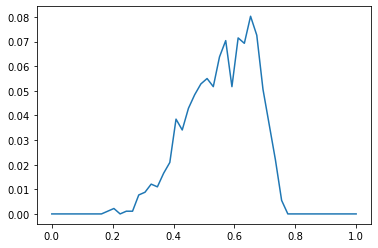

In [185]:
bins, rdf, op = orderparameter(o, o, hbox, 1, 50, 4, 3)
plt.plot(bins,rdf/909)
print(op)

In [7]:
def op_average(u, array, fs_atom_name, sn_atom_name , box, x_max, n_bins, n_neigh, l):

    '''
    Input:
      array(numpy.ndarray) : (n_time_frames)  ex) [0,100,200,300...,1000]
      
    output:
      bins(numpy.ndarray) : (n_bins,) array of bins
      gr_average(numpy.ndarray) : (n_bins, ) radial distribution function
      nr_average(numpy.ndarray) : (n_bins, ) number of cumulative molecules
    
    '''
    
    u.trajectory[0]
    p = u.select_atoms(fs_atom_name)
    o = p.atoms.positions
    N = o.shape[0] # number of molecules

    
    rdf__ = np.zeros(n_bins)
    opp = np.zeros((N,))
    n_bins = n_bins
    
    for i in array:
        u.trajectory[np.int(i)]
        p = u.select_atoms(fs_atom_name)
        pp = u.select_atoms(sn_atom_name)
        bins, rdf_, op = orderparameter(p.atoms.positions, pp.atoms.positions, box, x_max, n_bins, n_neigh, l)
        rdf__ += rdf_
        opp += op

    
    return bins, rdf__/len(array), op#opp/len(array)

In [47]:
wbins, wrdf_, wop = op_average(uw, np.linspace(0,250,20),"name OW", "name OW", wbox, 1, 50, 4, 3)

In [48]:
hbins, hrdf_, hop = op_average(uh, np.linspace(0,1000,20),"name OW", "name OW", hbox, 1, 50, 4, 3)

In [49]:
cbins, crdf_, cop = op_average(uc, np.linspace(0,1000,20),"name OW", "name OW", cbox, 1, 50, 4, 3)

In [93]:
x= np.array([[11, 12, 13, 22], [21, 7, 23, 14], [31, 10, 33, 7]])
print(x)
np.savetxt('test.out', (wrdf_,hrdf_,crdf_))   # x,y,z equal sized 1D arrays

[[11 12 13 22]
 [21  7 23 14]
 [31 10 33  7]]


In [104]:
import pandas as pd
import numpy as np

a = wbins
b = wrdf_/909
c = wwrdf_/909

d = hbins
e = hrdf_/1024
f = hhrdf_/1024

g = cbins
h = crdf_/1000
i = ccrdf_/1000

df = pd.DataFrame({"wbins" : a, "P(water3)" : b, "P(water6)" : c, "hbins" : d, "P(hice3)" : e, "P(hice6)" : f, "cbins" : g, "P(cice3)" : h, "P(cice6)" : i})
df.to_csv("submission2.csv", index=False)

In [201]:
a = wbins
b = wrdf_/909
c = wwrdf_/909
cc = wop
ccc = wwop

d = hbins
e = hrdf_/1024
f = hhrdf_/1024
ff = hop
fff = hhop

g = cbins
h = crdf_/1000
i = ccrdf_/1000
ii = cop
iii = ccop

x = []
x = x + [a] + [b] + [c] + [cc] + [ccc] + [d] +[e] +[f] + [ff] + [fff] +  [g] +[h] +[i] + [ii] + [iii]

import csv

csvfile = "csvfile.csv"

with open(csvfile, "w") as output:
   writer = csv.writer(output, lineterminator='\n')
   for line in x:
       writer.writerow(line)   

In [166]:
aa = a[0].item()
print(type(aa))

<class 'float'>


In [153]:
import csv
with open('eggs.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=' ',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['Spam'] * 5 + ['Baked Beans'])
    spamwriter.writerow(['Spam', 'Lovely Spam', 'Wonderful Spam'])

In [ ]:
np.savetxt("20bins", bins)
np.savetxt("histo_ice_20times_20bins_l3_4neighbors", rdf_/1024)
np.savetxt("op_ice_20times_20ins_l3_4neighbors", op)

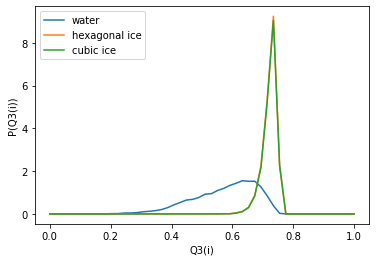

In [55]:
plt.plot(wbins, wrdf_/50, label='water')
plt.plot(hbins, hrdf_/50, label='hexagonal ice')
plt.plot(cbins,crdf_/50, label='cubic ice')
plt.xlabel("Q3(i)")
plt.ylabel("P(Q3(i))")

plt.legend()

In [50]:
wwbins, wwrdf_, wwop = op_average(uw, np.linspace(0,250,20),"name OW", "name OW", wbox, 1, 50, 4, 6)

In [51]:
hhbins, hhrdf_, hhop = op_average(uh, np.linspace(0,1000,20),"name OW", "name OW", hbox, 1, 50, 4, 6)

In [52]:
ccbins, ccrdf_, ccop = op_average(uc, np.linspace(0,1000,20),"name OW", "name OW", cbox, 1, 50, 4, 6)

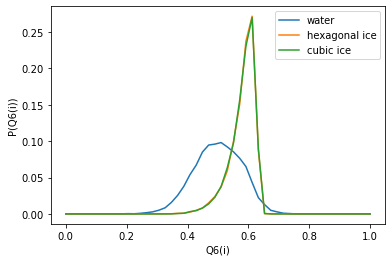

In [54]:
plt.plot(wwbins, wwrdf_/909, label='water')
plt.plot(hhbins, hhrdf_/1024, label='hexagonal ice')
plt.plot(ccbins,ccrdf_/1000, label='cubic ice')
plt.xlabel("Q6(i)")
plt.ylabel("P(Q6(i))")


plt.legend()

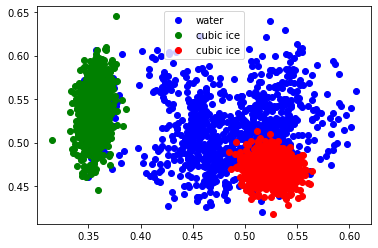

In [68]:
plt.plot(wop, wwop, 'bo', label= 'water')
plt.plot(hop, hhop, 'go', label= 'cubic ice')
plt.plot(cop, ccop, 'ro', label= 'cubic ice')
plt.legend()

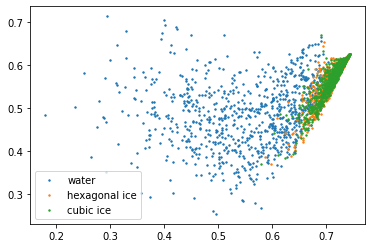

In [197]:
plt.scatter(wop, wwop, s=2, label = 'water')
plt.scatter(hop, hhop, s=2, label = 'hexagonal ice')
plt.scatter(cop, ccop, s=2, label = 'cubic ice')
plt.legend()


In [81]:
print(hop)

[0.70943412 0.71279363 0.71071585 ... 0.70982904 0.72068824 0.71491048]


In [10]:
def gop_average(u, array, fs_atom_name, sn_atom_name , box, x_max, n_bins, n_neigh, l):

    '''
    Input:
      array(numpy.ndarray) : (n_time_frames)  ex) [0,100,200,300...,1000]
      
    output:
      bins(numpy.ndarray) : (n_bins,) array of bins
      gr_average(numpy.ndarray) : (n_bins, ) radial distribution function
      nr_average(numpy.ndarray) : (n_bins, ) number of cumulative molecules
    
    '''
    
    u.trajectory[0]
    p = u.select_atoms(fs_atom_name)
    o = p.atoms.positions
    N = o.shape[0] # number of molecules

    
    op = 0
    
    for i in array:
        u.trajectory[np.int(i)]
        p = u.select_atoms(fs_atom_name)
        pp = u.select_atoms(sn_atom_name)
        a = global_st(p.atoms.positions, pp.atoms.positions, box, x_max, n_bins, n_neigh, l)
        op = op + a

    
    return op/len(array)

In [42]:
gwwop = gop_average(uw, np.linspace(0,250,20),"name OW", "name OW", wbox, 1, 50, 4, 3)
ghhop = gop_average(uh, np.linspace(0,250,20),"name OW", "name OW", hbox, 1, 50, 4, 3)
gccop = gop_average(uc, np.linspace(0,250,20),"name OW", "name OW", cbox, 1, 50, 4, 3)
print(gwwop,ghhop,gccop)

(-0.0006766704445930464+0.00010097081098161303j)
(0.00028481671375210973-0.000878855951938722j)
(-0.0008784541298169901+0.00044257220090034526j)
(-0.001058119945959989+0j)
(0.0008784541298169856+0.00044257220090034493j)
(0.0002848167137521105+0.0008788559519387214j)
(0.0006766704445930445+0.00010097081098161272j)
(0.0006297374800808739+0.0009406665865651261j)
(0.00044545670792455134+0.00047699715017055774j)
(0.001006184537453928-0.0004079335476312307j)
(0.0023175819571687054+0j)
(-0.0010061845374539273-0.00040793354763123097j)
(0.00044545670792455025-0.0004769971501705578j)
(-0.000629737480080873+0.0009406665865651243j)
(0.001243784440525519+0.00020930126758008304j)
(-0.0010835679271885192+0.0007525590953184491j)
(-0.00021621695177106596-0.0006999429425617287j)
(-0.0005279638082781338+0j)
(0.00021621695177106304-0.0006999429425617297j)
(-0.0010835679271885197-0.0007525590953184471j)
(-0.001243784440525518+0.0002093012675800804j)
(-0.0009438404480735878+0.0004073387204633548j)
(0.000498

(-1.4390551874725365e-10+6.269472972103096e-08j)
(-2.011129355227164e-10-8.144696428559863e-08j)
(2.012517049409683e-09+0j)
(2.0111293424877885e-10-8.144696428698099e-08j)
(-1.4390551880824002e-10-6.269472972108517e-08j)
(1.3246724915442522e-09-1.9893799961615824e-08j)
(9.367219988839028e-10-2.215133135149679e-08j)
(2.2430295420450513e-10+8.250654559424441e-08j)
(2.7796364293402806e-10-1.1762326859832508e-07j)
(4.576549490667003e-10+0j)
(-2.779636411993046e-10-1.1762326859650904e-07j)
(2.2430295512099478e-10-8.250654559389882e-08j)
(-9.367219991752822e-10-2.2151331351740735e-08j)
(4.5412450161064666e-10+1.1787462866137861e-09j)
(-1.8405865333226255e-09+4.2227257092732615e-09j)
(-2.312118149933387e-10+4.468216213178314e-09j)
(-3.1395047767420912e-09+0j)
(2.3121181423439718e-10+4.468216214587777e-09j)
(-1.8405865325484374e-09-4.2227257087853705e-09j)
(-4.541245015835416e-10+1.1787462862343154e-09j)
(3.023962886755519e-09-4.0211857631135446e-10j)
(1.5505649803677305e-10-2.575422805315493e

(-1.702123712844783e-10-4.25194353892433e-10j)
(3.5005157838358114e-10+2.6552640991495125e-10j)
(1.1837687550753095e-09+0j)
(-3.5005157861256464e-10+2.65526410456185e-10j)
(-1.7021237138509226e-10+4.2519435497490047e-10j)
(2.0469715475424089e-10+6.779992614558417e-11j)
(-4.453936500448119e-10+9.201276583471752e-10j)
(-1.7508300957647106e-10+7.129780066339464e-11j)
(-3.939773328409668e-10-8.984815784013334e-10j)
(1.6693589102723116e-09+0j)
(3.93977333222606e-10-8.984815783597e-10j)
(-1.75083009482796e-10-7.129780377201911e-11j)
(4.453936508497236e-10+9.2012765888147e-10j)
(4.5080794721513717e-10-2.8596204334346843e-10j)
(-2.747475852035719e-10+4.1887883239777327e-10j)
(1.2741059730175808e-09-1.0202682953833198e-09j)
(1.4601482208262406e-09+0j)
(-1.2741059740306593e-09-1.0202682955047504e-09j)
(-2.747475851758163e-10-4.1887883406310777e-10j)
(-4.50807946965337e-10-2.859620433781629e-10j)
(-1.1945613987568438e-10-4.3221858047129413e-10j)
(1.5539295746963555e-09+1.3238487361899588e-11j)
(1

In [33]:
print(wwop)

0.021803219854976248


In [118]:
def global_st(pos_A, pos_B, box,x_max, n_bins, n_neigh, l):
    
#For 4 neighbors
    
    o = pos_A
    N = o.shape[0] # number of molecules
    dist = np.abs(o[:, np.newaxis, :] - o)
    ddist = np.abs(dist - box)
    dist = np.minimum(dist, ddist)
    dist = np.reshape(dist*dist, (N*N,3))
    dist = np.sum(dist,axis = 1)
    dist = np.sqrt(dist)



    n = n_neigh #number of neighbors
    neighbor_list = np.zeros((N,n))


    for i in range(N):
        distij = dist[i*(N):(i+1)*(N)] #make (N,) distance vector
        list = np.argsort(distij)
        neighbor_list[i,:] = list[1:n+1]
    

    a = 0
    for k in range(-l,l+1):
        s = 0
        for i in range(N):
#             print(i,neighbor_list[i])
            s = s + steinhardt(k,l,i,neighbor_list[i],o,box)
        s = s/N
        print(s)
        s = np.absolute(s*np.conjugate(s))
        a = a + s
    
    op = np.sqrt(4*np.pi/(2*l+1)*a)


    

    return op,neighbor_list

In [34]:
def gop_average_cutoff(u, array, fs_atom_name, sn_atom_name , box, x_max, n_bins, cutoff, l):

    '''
    Input:
      array(numpy.ndarray) : (n_time_frames)  ex) [0,100,200,300...,1000]
      
    output:
      bins(numpy.ndarray) : (n_bins,) array of bins
      gr_average(numpy.ndarray) : (n_bins, ) radial distribution function
      nr_average(numpy.ndarray) : (n_bins, ) number of cumulative molecules
    
    '''
    
    u.trajectory[0]
    p = u.select_atoms(fs_atom_name)
    o = p.atoms.positions
    N = o.shape[0] # number of molecules

    
    op = 0
    
    for i in array:
        u.trajectory[np.int(i)]
        p = u.select_atoms(fs_atom_name)
        pp = u.select_atoms(sn_atom_name)
        a = global_st_cutoff(p.atoms.positions, pp.atoms.positions, box, x_max, n_bins, cutoff, l)
        op = op + a

    
    return op/len(array)

In [119]:
def global_st_cutoff(pos_A, pos_B, box,x_max, n_bins, cutoff, l):
    
#For distance
    
    o = pos_A
    N = o.shape[0] # number of molecules
    dist = np.abs(o[:, np.newaxis, :] - o)
    ddist = np.abs(dist - box)
    dist = np.minimum(dist, ddist)
    dist = np.reshape(dist*dist, (N*N,3))
    dist = np.sum(dist,axis = 1)
    dist = np.sqrt(dist)



    neighbor_list = []


    for i in range(N):
        distij = dist[i*(N):(i+1)*(N)] #make (N,) distance vector
        list = np.argsort(distij)
        distij = np.sort(distij)


        k = 1
        arr = []
        while distij[k] < cutoff:
            arr += [list[k]]
            k += 1
        arr = np.array(arr)
        neighbor_list += [arr]
    

    a = 0
    for k in range(-l,l+1):
        s = 0
        for i in range(N):
#             print(i,neighbor_list[i])
            s = s + steinhardt(k,l,i,neighbor_list[i],o,box)
        s = s/N
        print(s)
        s = np.absolute(s*np.conjugate(s))
        a = a + s
    
    op = np.sqrt(4*np.pi/(2*l+1)*a)
    
#     print(neighbor_list)


    

    return op,neighbor_list

In [36]:
gwwop = gop_average_cutoff(uw, np.linspace(0,250,20),"name OW", "name OW", wbox, 1, 50, 3.5, 3)
ghhop = gop_average_cutoff(uh, np.linspace(0,250,20),"name OW", "name OW", hbox, 1, 50, 3.5, 3)
gccop = gop_average_cutoff(uc, np.linspace(0,250,20),"name OW", "name OW", cbox, 1, 50, 3.5, 3)
print(gwwop,ghhop,gccop)

0.0026713757086621413 0.00021777841550165694 0.00017304186427640739


In [37]:
gwwop = gop_average_cutoff(uw, np.linspace(0,250,20),"name OW", "name OW", wbox, 1, 50, 3.5, 4)
ghhop = gop_average_cutoff(uh, np.linspace(0,250,20),"name OW", "name OW", hbox, 1, 50, 3.5, 4)
gccop = gop_average_cutoff(uc, np.linspace(0,250,20),"name OW", "name OW", cbox, 1, 50, 3.5, 4)
print(gwwop,ghhop,gccop)

0.022442875702126212 0.23374501965637298 0.45130211139304777


In [38]:
gwwop = gop_average_cutoff(uw, np.linspace(0,250,20),"name OW", "name OW", wbox, 1, 50, 3.5, 5)
ghhop = gop_average_cutoff(uh, np.linspace(0,250,20),"name OW", "name OW", hbox, 1, 50, 3.5, 5)
gccop = gop_average_cutoff(uc, np.linspace(0,250,20),"name OW", "name OW", cbox, 1, 50, 3.5, 5)
print(gwwop,ghhop,gccop)

0.002362045413123792 0.00011172846339566164 0.00010437134769985313


In [39]:
gwwop = gop_average_cutoff(uw, np.linspace(0,250,20),"name OW", "name OW", wbox, 1, 50, 3.5, 6)
ghhop = gop_average_cutoff(uh, np.linspace(0,250,20),"name OW", "name OW", hbox, 1, 50, 3.5, 6)
gccop = gop_average_cutoff(uc, np.linspace(0,250,20),"name OW", "name OW", cbox, 1, 50, 3.5, 6)
print(gwwop,ghhop,gccop)

0.02061096208574381 0.40899585554044 0.48698943225995917


In [40]:
gwwop = gop_average_cutoff(uw, np.linspace(0,250,20),"name OW", "name OW", wbox, 1, 50, 3.5, 7)
ghhop = gop_average_cutoff(uh, np.linspace(0,250,20),"name OW", "name OW", hbox, 1, 50, 3.5, 7)
gccop = gop_average_cutoff(uc, np.linspace(0,250,20),"name OW", "name OW", cbox, 1, 50, 3.5, 7)
print(gwwop,ghhop,gccop)

0.0025136406120486116 0.00014278775548329548 0.00013786097975587518


In [122]:
uw.trajectory[10]
pw = uw.select_atoms("name OW")
gwop,gneighbor_list = global_st(pw.atoms.positions, pw.atoms.positions, wbox, 1, 20, 4, 3)
print(gwop)

-1.0000007
1.0000006
(0.0003351521711811617-0.001236145760909215j)
-1.0000007
1.0000006
(-0.0007738078779958091+0.00041836919818451077j)
-1.0000007
1.0000006
(-0.0006377319898828216-0.0014567316697222865j)
-1.0000007
1.0000006
(-0.0010861273264213857+0j)
-1.0000007
1.0000006
(0.0006377319898828202-0.0014567316697222865j)
-1.0000007
1.0000006
(-0.0007738078779958091-0.00041836919818451066j)
-1.0000007
1.0000006
(-0.0003351521711811624-0.0012361457609092149j)
0.004457007924702342


In [164]:
uw.trajectory[14]
pw = uw.select_atoms("name OW")
gwop,gneighbor_list_cutoff = global_st_cutoff(pw.atoms.positions, pw.atoms.positions, wbox, 1, 20, 3.5, 3)
print(gwop)

-1.0000001
1.0000001
-1.0000001
1.0000004
(0.00015772897001864068+0.00045584257738954414j)
-1.0000001
1.0000001
-1.0000001
1.0000004
(0.00020183414881576615+0.0002853051193800423j)
-1.0000001
1.0000001
-1.0000001
1.0000004
(0.00026663050501437327+0.00033757956680620116j)
-1.0000001
1.0000001
-1.0000001
1.0000004
(-0.0006122560675305961+0j)
-1.0000001
1.0000001
-1.0000001
1.0000004
(-0.0002666305050143738+0.0003375795668062036j)
-1.0000001
1.0000001
-1.0000001
1.0000004
(0.00020183414881576667-0.000285305119380044j)
-1.0000001
1.0000001
-1.0000001
1.0000004
(-0.0001577289700186402+0.0004558425773895423j)
0.001615935261668649


In [125]:
print(gneighbor_list)

[[867. 115. 588. 836.]
 [831. 585. 790.   3.]
 [452.  98. 458. 849.]
 ...
 [ 63. 857. 455. 344.]
 [318. 331. 707. 654.]
 [427. 151.  19. 641.]]


In [126]:
print(gneighbor_list_cutoff)

[array([867, 115, 588, 836, 873], dtype=int64), array([831, 585, 790,   3], dtype=int64), array([452,  98, 458, 849, 821, 358], dtype=int64), array([340, 660, 405,   1], dtype=int64), array([430, 818, 750, 265], dtype=int64), array([171, 286, 603, 393, 849], dtype=int64), array([484, 594, 498], dtype=int64), array([582, 447,  48, 250], dtype=int64), array([103, 441, 223, 634], dtype=int64), array([834, 126, 591, 805, 467], dtype=int64), array([433, 336,  82, 355, 300], dtype=int64), array([321, 874, 835, 519], dtype=int64), array([147, 456, 295, 139, 168], dtype=int64), array([532, 391, 612, 586, 769, 140], dtype=int64), array([438, 748, 707, 417, 361], dtype=int64), array([691, 781,  22,  66, 436], dtype=int64), array([287, 476, 233, 186], dtype=int64), array([474,  66, 762, 182, 283,  90, 339], dtype=int64), array([792, 819, 450, 495], dtype=int64), array([552, 532, 908, 199, 729], dtype=int64), array([179, 526, 640, 512, 153,  72, 201], dtype=int64), array([461, 730, 221, 174,  42, 

In [165]:
gn = gneighbor_list_cutoff
aa = np.zeros(len(gn),)
for i in range(len(gn)):
    a = gn[i]
    b = a.size

    for k in range(a.size):

        p = np.int(a[k])
        aa[p] += 1
print(aa.shape)
print(np.sum(aa))

(909,)
4494.0


In [160]:
b = gn[0]
a = 0
b = gn[a]
print(b)
print(b.size)

[867 115 588 836 873]
5


In [113]:
uc.trajectory[13]
pw = uc.select_atoms("name OW")
gcop = global_st_cutoff(pw.atoms.positions, pw.atoms.positions, cbox, 1, 20, 3.5, 3)
print(gcop)

(1.8913117862229887e-05-9.083591530677005e-06j)
(2.0943252706158685e-05+0.0001321771103733891j)
(-2.1240890474808023e-05-1.2968970454603164e-05j)
(1.3177896592957685e-05+0j)
(2.12408904748081e-05-1.2968970454603303e-05j)
(2.0943252706158722e-05-0.00013217711037338676j)
(-1.891311786222986e-05-9.083591530676088e-06j)
0.00026156809988236567


In [102]:
uh.trajectory[10]
pw = uh.select_atoms("name OW")

ghop = global_st_cutoff(pw.atoms.positions, pw.atoms.positions, hbox, 1, 20, 3.5, 3)
print(ghop)

(3.147660828002347e-11-1.1007540814988222e-09j)
(-1.8445548307353694e-10+2.910424236546782e-10j)
(6.338203152969103e-11+1.930524636147273e-09j)
(1.3603225286658305e-09+0j)
(-6.338203001180799e-11+1.9305246364454288e-09j)
(-1.8445548364274308e-10-2.910424237088883e-10j)
(-3.1476609167714e-11-1.1007540821764486e-09j)
4.636560084432269e-09


In [90]:
uw.trajectory[2]
pw = uw.select_atoms("name OW")
gwop = global_st(pw.atoms.positions, pw.atoms.positions, wbox, 1, 20, 4, 3)
print(gwop)

(-0.00024026255475518933-0.0005012162228265754j)
(0.0004407503393074294-0.0004598433468770741j)
(-0.0004519242281741+0.00032547908206805157j)
(-0.0008330942469046628+0j)
(0.00045192422817410025+0.0003254790820680516j)
(0.00044075033930742987+0.00045984334687707387j)
(0.0002402625547551902-0.0005012162228265754j)
0.0022193465801802407


In [48]:
uc.trajectory[50]
pw = uc.select_atoms("name OW")
gcop = global_st(pw.atoms.positions, pw.atoms.positions, cbox, 1, 20, 4, 4)
print(gcop)

(-0.17477209345031125-0.0006295703121819512j)
(0.001384417902342481+0.0003290267662781767j)
(-0.00034033578683589157-0.00013550929505513085j)
(0.0009470850237354117-0.00106744472268458j)
(-0.2938840368148326+0j)
(-0.0009470850237354116-0.0010674447226845787j)
(-0.0003403357868358904+0.0001355092950551315j)
(-0.0013844179023424807+0.000329026766278176j)
(-0.17477209345031125+0.0006295703121819498j)
0.45376600241618226


In [43]:
uh.trajectory[50]
ph = uh.select_atoms("name OW")
ghop = global_st(ph.atoms.positions, ph.atoms.positions, hbox, 1, 20, 4, 3)
print(ghop)

(9.187308161825612e-11+6.965944091084225e-10j)
(4.4997333316764017e-10-7.066344680856302e-10j)
(-2.3010953136438222e-10-8.104742049740762e-10j)
(1.1500939210519804e-09+0j)
(2.301095311475418e-10-8.104742051096014e-10j)
(4.499733336080973e-10+7.066344685870737e-10j)
(-9.187308206548951e-11+6.96594410843146e-10j)
3.035679301260267e-09


In [44]:
uc.trajectory[50]
pc = uc.select_atoms("name OW")
gcop = global_st(pc.atoms.positions, pc.atoms.positions, cbox, 1, 20, 4, 3)
print(gcop)

(1.77195505310368e-10+1.2788172547364973e-09j)
(-7.475672727727534e-10-7.76771513777419e-12j)
(3.0696508460104076e-11+8.35426240373971e-11j)
(-2.084619391135023e-10+0j)
(-3.0696507821725836e-11+8.354262458903916e-11j)
(-7.475672732445981e-10+7.767717691287147e-12j)
(-1.7719550463035638e-10+1.2788172545491473e-09j)
2.845619362912175e-09


In [37]:
uc

<Universe with 4000 atoms>

In [11]:
uw.trajectory[5]
pw = uw.select_atoms("name OW")
o = pw.atoms.positions
N = o.shape[0] # number of molecules
dist = np.abs(o[:, np.newaxis, :] - o)
ddist = np.abs(dist - wbox)
dist = np.minimum(dist, ddist)
dist = np.reshape(dist*dist, (N*N,3))
dist = np.sum(dist,axis = 1)
dist = np.sqrt(dist)


l = 3
n = 4 #number of neighbors
neighbor_list = np.zeros((N,n))


for i in range(N):
    distij = dist[i*(N):(i+1)*(N)] #make (N,) distance vector
    list = np.argsort(distij)
    neighbor_list[i,:] = list[1:n+1]

op = np.zeros((N,))
for i in range(N):
    a = 0
    for k in range(-l,l+1):
        s = np.square(np.absolute(steinhardt(k,l,i,neighbor_list[i],o,wbox)))
        a = a + s
    op[i] = np.sqrt(4*np.pi/(2*l+1)*a)

In [12]:
neighbor_list

array([[696., 867., 760., 379.],
       [537.,   3., 340., 588.],
       [ 98., 587., 744., 455.],
       ...,
       [358., 821.,  63., 473.],
       [318., 707.,  49., 654.],
       [136., 182.,  62., 427.]])

In [13]:
neighbor_list[696]

array([503., 604.,   0., 248.])

In [59]:
theta, phi = angle(0,np.intc(neighbor_list[0,0]),o,wbox)
m = -3
print(theta,phi)
a = sp.sph_harm(m,l,phi,theta)
print(a)

thetaa, phii = angle(696,np.intc(neighbor_list[696,2]),o,wbox)
m = -3
print(thetaa,phii)
b = sp.sph_harm(m,l,phii,thetaa)
print(b)

1.2746347 5.077691380177633
(-0.3246715017115032-0.16692398431895838j)
1.866958 1.9360988
(0.32467151950774903+0.16692388580941103j)


In [47]:
a = 1+1j
b = np.exp(3j*phi)
print(b)
bb = np.exp(3j*(phii))
print(bb)

(-0.8893434224525174+0.4572398461862692j)
(0.8893435423720226-0.4572396129396297j)


In [44]:
phi - phii

3.141592566167013

In [62]:
a = 1 +1j
b = np.conjugate(a)
c = a*b

In [63]:
c

(2+0j)

In [106]:
a = sp.sph_harm(3,3,2,4)
print (a)

(-0.17364609733091124+0.05053208943309394j)


In [ ]:
a = sp.sph_harm(m,l,phi,theta)